# **AM 207**: Homework 2

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 3rd, 2015**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW2.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW2.tar.gz or AM207_YOURNAME_HW2.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

/Users/Grace/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Problem 1: Geweke Convergence Test

In the lecture we have seen the Geweke test as one option to test for convergence of our metropolis hastings chain. Describe in your own words how the Geweke test works and its limitations. 

We provide you with the following code for the Geweke test. Write comments for the marked lines and any lines you think would be good to explain in addition. 

Write a short explanation of what the `rhot` function does and why it is necessary.

## 1) How the Geweke test works and its limitations

The Geweke test compares values in the early part of the Markov chain to those in the latter part of the chain in order to detect failure of **convergence**. When we see the given code below, the statistic is constructed as follows. First, if we split the trace into 2 chunks, two subsequences of the Markov chain (**sub_trace_a** and **sub_trace_b**) are taken out, starting from the beginning of each chunk, with size of given parameter **'length'**. Therefore, in the loop there will be **'interval'** number of chunks for each (sub_trace_a, sub_trace_b). By splitting the time-series into several segements in this way, Geweke test compares the mean and variance of segements from the beginning and the end of a single chain. 

When we see our code, $\bar{\theta_a}$ and $\bar{\theta_b}$ is defined as following.

$$ \bar{\theta }_a = \frac{1}{n_1} \sum _{t=1}^{n_1} \theta_t \;  \;  \mbox{and} \;  \;  \bar{\theta }_b = \frac{1}{n_2} \sum _{t=n_ a}^{n} \theta_t $$

where $\theta_a$ index moves from $[ 1, \dots , n_1]$ and $\theta_b$ index moves from $[n_a, \dots , n]$, where $1<n_1<n_ a<n$ and $n_2 = n - n_ a + 1$.
Then, when we see the z-score formula in the given code, it is written as this, (I'll explain **n_ESS** when explaining **rhot function** at below)

$$z=\frac{\bar{\theta_a}-\bar{\theta_b}}{\sqrt{\frac{Var(\theta_a)}{n_{ESS}}+\frac{Var(\theta_b)}{n_{ESS}}}}$$

Since ratios $n_1/n$ and $n_2/n$ are fixed, then $(n_1+n_2)/n < 1$, and the chain is stationary, then the following z-score converges to a **standard normal distribution** as $n \rightarrow \infty $. That is why we can use this **z-score** as an evidence of convergence. As it will follow the standard normal distribution, **95% confidence interval** would be range from -2 to 2, therefore we say that **any value below 2 is considered convergence**.

However, Geweke test also has its own limitation. This z-score can be applied to a single sampler chain only. Also, we choose the **length** and **interval** by ourselves, this diagnostic result is subjective to the choice of the users.


(refrence : http://support.sas.com/documentation/cdl/en/statug/65328/HTML/default/viewer.htm#statug_introbayes_sect024.htm )


## 2) Write comments for the marked lines and any lines you think would be good to explain in addition. 

In [94]:
# rhot function calculates the auto-correlation coefficient of the former and latter chunk of x
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# Geweke function that tests convergence
def Geweke(trace, intervals, length):
    nsl=length
    # jump is the each chunk size
    jump = int(0.9*len(trace)/(2*intervals))
    # Geweke starts calculating from 10% of total length, and this is to cut-off the burn-in part
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    # loop to make 'interval' number of chunks 
    for k in np.arange(0, intervals):
        # the early segment starting point
        baga = np.int(first+k*jump)
        # the latter segement starting point
        bagb = len(trace)/2 + k*jump
        
        # sub trace segements extraction
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        # compute the means of each segement
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # this is to cut-off the burn-in part of each chunk (we assume early 10% data as burn-in)
        for i in xrange(int(0.1*nsl)):
            # sum up auto-correlation coefficient to compute Effective Sample Size later
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # compute variance with considering Effective Sample Size
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        # compute the z-score to see if our chain converges
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z

## 3) Write a short explanation of what the `rhot` function does and why it is necessary.

When we see the code for `rhot` function, it computes the **auto-correlation coefficient** for the given segement. This is computed for later use of **Effective Sample Size**.

**Effective Sample Size** is the the size of given samples that excludes the samples that are auto-correlated to each other. 

$$n_{ESS} = \frac{n}{1+2\sum_{k=1}^{\infty}\rho_k}$$

Since the traces (Markov chain) we compute for Geweke test is a kind of time-series, so each point might be correlated at different time step. Therefore, to get the size of samples that are independent, we compute auto-correlation coefficients, thereby getting Effective-Sample-Size. If auto-correlation coefficient is high, then it means our Effective-Sample-Size is small, therefore, our sample might not be able to give reliable distribution. Whereas lower auto-correlation indicates samples are more independent, therefore, it has higher efficiency and we can rely on our estimate.

# Problem 2: Message Response Times

The file `hangout_chat_data.csv` contains the response times of your friend Mark to google hangout chat messages in seconds. Use a method of your choice to read the file into a data frame or a numpy array. Your goal for this problem is to model Mark's chat response time distribution in a Bayesian framework. 

The description of the data sounds like a Poisson distribution is a good choice for our likelihood. We have messages arriving independently of each other, and instead of the arrival time we consider the time it took Mark to respond to the messages. 

* Load and describe the data by plotting a histogram of the response times. 
* Derive and compute the maximum likelihood solution for a Poisson distribution.
* Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

* Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 
* Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

* Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

* Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 


## 1) Load and describe the data by plotting a histogram of the response times. 

In [396]:
import pandas as pd
df=pd.read_csv('hangout_chat_data.csv', delimiter='\r',header=None)
message_response_times = np.array(np.transpose(df.values)[0])
print message_response_times[:20]
print len(message_response_times)

[12 38 12 23 11 50 49 23 16  7 45 12  1  6 23 51 30 14 17 19]
266


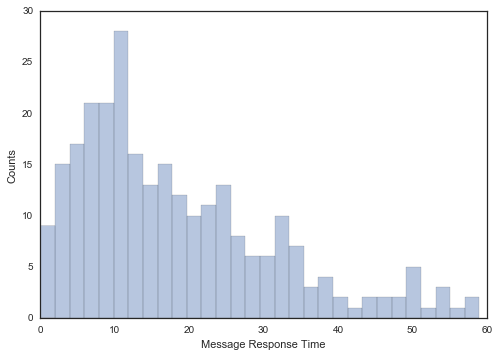

In [223]:
plt.hist(message_response_times, bins=30, alpha=0.4)
plt.xlabel('Message Response Time')
plt.ylabel('Counts')

## 2) Derive and compute the maximum likelihood solution for a Poisson distribution.

As stated in our problem, if the likelihood of our data ($x_{1}, x_{2}, \dots, x_{n}$) follows the Poisson distribution, then it can be written as follows : 
$$Likelihood = P(\bf{x}|\lambda) = e^{-\lambda}\frac{\lambda^{\bf{x}}}{\bf{x}!}$$
As each data is independent to each other, the formula above can be written as the product of each data point Likelihood.
$$P(\bf{x}|\lambda) = \prod_{n=1}^{N} P(x_{i}|\lambda) = e^{-\lambda}\frac{\lambda^{x_{i}}}{x_{i}!}$$
To estimate Maximum Likelihood, let's have log-likelihood.
$$Log Likelihood =\prod_{n=1}^{N} P(x_{i}|\lambda) = e^{-\lambda}\frac{\lambda^{x_{i}}}{x_{i}!}
= \sum_{n=1}^{N} \Big(-\lambda + x_{i}\ln\lambda - \ln(x_{i}!)\Big) = -N\lambda + \ln\lambda \sum_{n=1}^{N}x_{i}- \sum_{n=1}^{N}\ln(x_{i}!)\Big)$$
If we take derivative w.r.t $\lambda$,
$$\frac{\partial}{\partial \lambda}Log Likelihood = -N + \frac{\sum_{n=1}^{N}x_{i}}{\lambda} = 0$$
$$\therefore \lambda = \frac{1}{N}\sum_{n=1}^{N}x_{i}$$

Therefore, lambda from MLE solution is the same as mean value of our data set.

In [37]:
lambda_MLE = message_response_times.mean()
print "lambda_MLE :", lambda_MLE

lambda_MLE : 18.0413533835


## 3) Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

1) I chose the **prior** as **Gamma** distribution for 2 reasons : First, it is reasonalbe to choose conjugate prior of Poisson distribution, which is our likelihood. Second, **support** range of the prior has to be from **0 to infinity** and Gamma was more simple to have that support range, rather than using truncated-normal distribution.

2) For the **alpha** parameter needed in Gamma distribution, I chose to use **lambda_MLE = 18.04xx** value. If we look up the **scipy.stats.gamma.pdf(x, a)** manual, it assumes **beta = 1** and since $\frac{\alpha}{\beta}$ should be near the mean value, so I chose it to be lambda_MLE that I got by Maximum Likelihood Estimation.

3) For **Metropolis Hastings**, when computing the ratio of $\frac{P(X^*)}{P(X)}$, since Poisson distribution has too small values, so python regard it as 0, so I adjusted the code to take log. Therefore, when computing the acceptance, I compared with **log(uniform variable)** against $\ln \frac{P(X^*)}{P(X)}$.

### 3.3.1. Define Prior, Likelihood and Posterior

In [617]:
# ===============================================
# Define Prior : P(lambda)
# based on Gamma distribution
# ===============================================
prior_problem2 = lambda _lambda : scipy.stats.gamma.pdf(_lambda, lambda_MLE)


# ===============================================
# Define Likelihood : P(X | lambda)
# based on Poisson distribution
# ===============================================
likelihood_problem2 = lambda x, _lambda : scipy.stats.poisson.pmf(x, _lambda)


# ===============================================
# Define Posterior : P(lambda | X)
# ===============================================
def calc_posterior(_lambda):
    # since likelihood is product of xi, we need to sum them up
    # and likelihood is very small value, so we'll take log
    # as we only need to compare the value, not the exact value
    log_likelihood = np.log(likelihood_problem2(message_response_times, _lambda))
    sum_of_log_likelihood = np.sum(log_likelihood)
    log_prior = np.log(prior_problem2(_lambda))
    p =  sum_of_log_likelihood + log_prior
    return p

### 3.3.2 Define Metropolis Hasting function

In [618]:
rnorm = np.random.normal
runif = np.random.rand
MAP_prob = 0
MAP_lambda = 0

def metropolis(n_iterations, initial_values, prop_std, doPrint=True):
    #################################################################
    # function to sample using Metropolis 
    # (assumes proposal distribution is symmetric)
    # 
    # n_iterations:  number of iterations
    # initial_values: multidimensional start position for our chain
    # prop_std: standard deviation for Gaussian proposal distribution 
    ##################################################################
    
    
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    # generates a list of length n_params
    #prop_sd = [prop_std]*n_params
    prop_sd = prop_std
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    # the * assigns the arguments of the function according to the list elements
    current_prob = calc_posterior(*trace[0])
    global MAP_prob
    global MAP_lambda
    MAP_prob = current_prob
    MAP_lambda = initial_values
    
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000 and doPrint: 
            print 'Iterations left: ', n_iterations-i
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        
        # loop over all dimensions
        for j in range(n_params):
            # proposed new value
            theta = rnorm(current_params[j], prop_sd[j])
            #print theta
            
            # Insert new value 
            p[j] = theta
    
            # Calculate posterior with proposed value
            proposed_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_prob - current_prob
    
            # Sample a uniform random variate
            u = np.log(runif())
    
            # Test proposed value
            if (u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1
                if MAP_prob < proposed_prob:
                    MAP_lambda = theta
            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            # update p so we search the next dimension according
            # to the current result
            p[j] = trace[i+1,j]
    
    # return our samples and the number of accepted steps
    return trace, accepted

### 3.3.3. Acceptance rate should be near 0.3
Let's look at the acceptance ratio to tune the stepsize. As rule of thumb, it is known to be good if the acceptance rate is near 0.3 and it probably should be better done after the burn in.

I tried several different **std** value to tue the acceptance ratio, and found out that **std = 1.0** works well.

[ 0.32044]


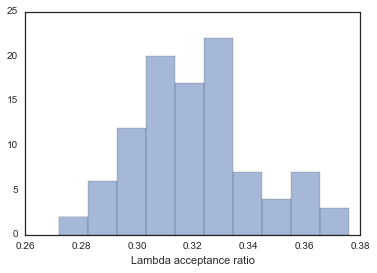

In [619]:
n_iter = 500
acc_ratios = []
for i in range(100):
    start_lambda = np.random.rand(1)*10
    trace, acc = metropolis(n_iter, (start_lambda), [1.0], doPrint=False)
    acc_ratios.append(acc/np.double(n_iter))

acc_ratios = np.array(acc_ratios)

plt.figure(figsize=(6,4))
plt.hist(acc_ratios[:,0], alpha=0.5)
plt.xlabel("Lambda acceptance ratio")
print np.mean(acc_ratios, axis=0)

### 3.3.4. Let's sample from MH

In [620]:
n_iter = 100000
trace, acc = metropolis(n_iter, (start_lambda), [1.0])
print acc/np.double(n_iter)

Iterations left:  100000
Iterations left:  90000
Iterations left:  80000
Iterations left:  70000
Iterations left:  60000
Iterations left:  50000
Iterations left:  40000
Iterations left:  30000
Iterations left:  20000
Iterations left:  10000
[ 0.3056]


### 3.3.5. Now see our Samples

Lambda at MLE : 18.0413533835
Lambda at MAP : 17.9844827284


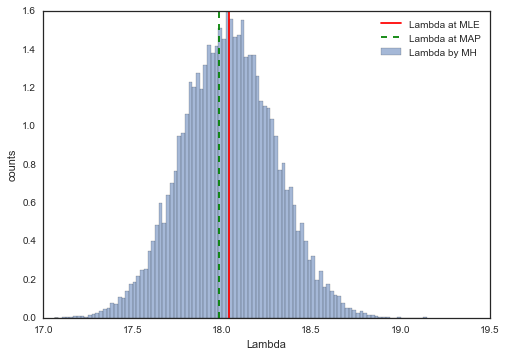

In [621]:
burnin = 10000    # MY BURN IN 
# throw away the burnin samples
lambda_MH = trace[burnin:, 0]

# histogram of lambda
fig=plt.hist(lambda_MH, bins=100, normed=True, alpha=0.5, label='Lambda by MH')
plt.axvline(x=lambda_MLE, color='r', label='Lambda at MLE')
plt.axvline(x=MAP_lambda, color='g', label='Lambda at MAP', linestyle='--')
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("counts")

print "Lambda at MLE :", lambda_MLE
print "Lambda at MAP :", MAP_lambda

## 4) Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 

If we see both **Traceplots** and **Geweke** test results below, they all indicate that the lambda value we estimated by Metropolis Hasting is converged.

### 3.4.1. Traceplots

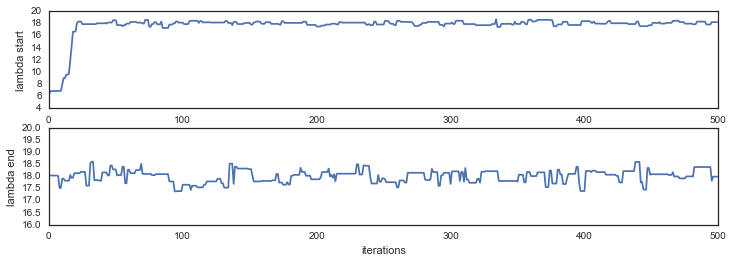

In [622]:
plt.figure(figsize=[12,8])

burnin = 500    # MY BURN IN 
# throw away the burnin samples
lambda_traceplot = trace[burnin:,0]

# trace plot for alpha during burnin
plt.subplot(4,1,1) 
plt.plot(trace[:burnin,0])
plt.ylim(4,20)
plt.xlabel("iterations")
plt.ylabel("lambda start")

# trace plot for alpha at the end 
# where we hopefully converged
plt.subplot(4,1,2) 
plt.plot(lambda_traceplot[-burnin:])
plt.ylim(16,20)
plt.xlabel("iterations")
plt.ylabel("lambda end")

### 3.4.2. Convergence test - Geweke

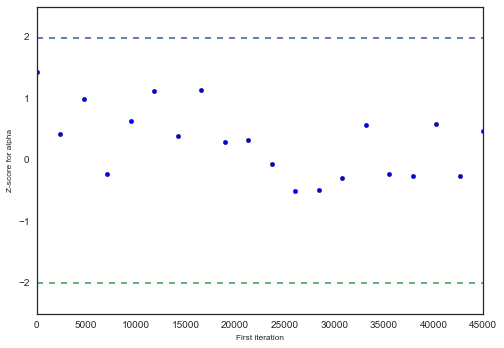

In [625]:
geweke_scores = pm.geweke(lambda_MH, first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "alpha")

## 5) Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

### 2.5.1. Compare the solution to a solution using the MCMC class in pymc

As we see in the **mcmc.summary()**, then mean value of **Lambda (mean value of Message Response Time)** is almost the same as the solution we got from MLE. So we can safely say that both MLE solution and MCMC estimation is correct.

In [627]:
lambda_pymc = pm.Gamma('lambda', alpha=np.sum(message_response_times), beta=len(message_response_times))
x_pymc = pm.Poisson('message_response_times', mu=lambda_pymc)

problem2_model = pm.Model([lambda_pymc, x_pymc])
mcmc = pm.MCMC(problem2_model)
mcmc.sample(iter=100000, burn=1000)

 [-----------------100%-----------------] 100000 of 100000 complete in 6.7 sec

In [629]:
mcmc.summary()


lambda:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	18.041           0.26             0.001          [ 17.537  18.558]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	17.532           17.865          18.04          18.216        18.553
	

message_response_times:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	18.026           4.268            0.014                [ 10.  26.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	10.0             15.0            18.0           21.0          27.0
	


Lambda at MLE : 18.0413533835


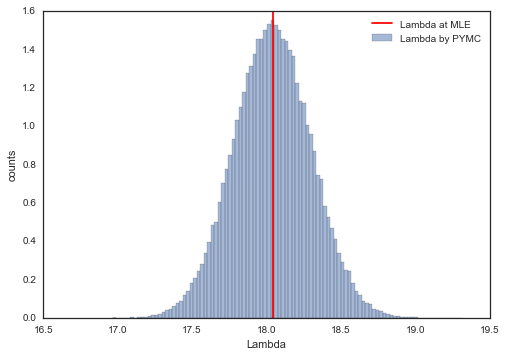

In [631]:
# histogram of alpha
fig=plt.hist(lambda_pymc.trace(), bins=100, normed=True, label='Lambda by PYMC', alpha=0.5)
plt.axvline(x=lambda_MLE, color='r', label='Lambda at MLE')
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("counts")

print "Lambda at MLE :", lambda_MLE

### 2.5.2.  Which parameters does your implementation need that the pymc implementation can do without?

In PYMC method, we did not need the **Proposal distribution** (accordingly we don't need to tune the standard deviation for appropriate step size) and the **uniform variable** needed when comparing with the Acceptance rate.

### 2.5.3 How do the traceplots compare? 

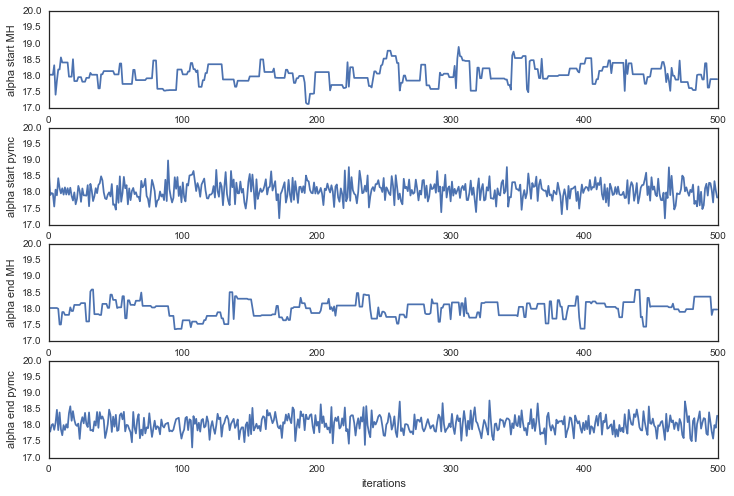

In [628]:
plt.figure(figsize=[12,8])

burnin = 500

# trace plot for alpha from our MH implementation
plt.subplot(4,1,1) 
plt.plot(lambda_MH[:burnin])
plt.ylim(17,20)
plt.xlabel("iterations")
plt.ylabel("alpha start MH")

# trace plot for alpha from pymc
plt.subplot(4,1,2) 
plt.plot(lambda_pymc.trace()[:burnin])
plt.ylim(17,20)
plt.xlabel("iterations")
plt.ylabel("alpha start pymc")

# trace plot for alpha from our MH implementation
plt.subplot(4,1,3) 
plt.plot(lambda_MH[-burnin:])
plt.ylim(17,20)
plt.xlabel("iterations")
plt.ylabel("alpha end MH")

# trace plot for alpha from pymc
plt.subplot(4,1,4) 
plt.plot(lambda_pymc.trace()[-burnin:])
plt.ylim(17,20)
plt.xlabel("iterations")
plt.ylabel("alpha end pymc")

## 6) Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

I chose to use MAP estimate for our posterior. So inside Metropolis Hasting function above, I defined 2 variables, which are `MAP_prob`, and `MAP_lambda` and this will store the labmda value at MAP moment.

log of MAP probability : -2417.4843459
lambda at MAP : 18.0203955397
lambda at MLE : 18.0413533835


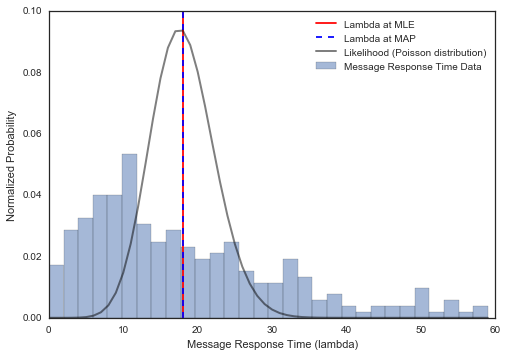

In [641]:
plt.hist(message_response_times, bins=30, alpha=0.5, normed=True, label='Message Response Time Data')
plt.axvline(x=lambda_MLE, color='r', label='Lambda at MLE')
plt.axvline(x=MAP_lambda, color='b', label='Lambda at MAP', linestyle='--')

xx = np.arange(0, 60)
likelihood_poisson_plot = scipy.stats.poisson.pmf(xx, 18.041) # this 18.041 is the value I got from PYMC estimation
plt.plot(xx, likelihood_poisson_plot, color='k', alpha=0.5, linewidth=2, label="Likelihood (Poisson distribution)")
plt.legend()
plt.xlabel("Message Response Time (lambda)")
plt.ylabel("Normalized Probability")

print "log of MAP probability :", MAP_prob
print "lambda at MAP :", MAP_lambda
print "lambda at MLE :", lambda_MLE

## 7) Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 

No, our model was not good since it cannot cover the fatty tail part in range of [30, 60]. So I come up with other distribution for likelihood, which is **negative Binomial**. And I set our prior to be uniform, since we beilive that there will not be any prejudiced inclination to the mean of Message Response Time.


In [600]:
lambda_pymc = pm.Uniform('lambda', 0.0, 60.0)
alpha_pymc = pm.Uniform('alpha', 0.0, 100.0)
likelihood_pymc = pm.NegativeBinomial('message_response_time', mu=lambda_pymc, alpha=alpha_pymc, value=message_response_times, observed=True)

problem2_new_model = pm.Model([lambda_pymc, alpha_pymc, likelihood_pymc])
mcmc = pm.MCMC(problem2_new_model)
mcmc.sample(iter=100000, burn=0)


 [-----------------100%-----------------] 100000 of 100000 complete in 16.7 sec

In [601]:
mcmc.summary()


lambda:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	18.111           0.857            0.008          [ 16.441  19.765]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	16.524           17.509          18.089         18.681        19.854
	

alpha:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.906            0.387            0.002            [ 1.55   2.245]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.574            1.78            1.898          2.02          2.279
	


log of MAP probability : -2417.4843459
lambda at MAP : 18.0203955397
lambda at MLE : 18.0413533835


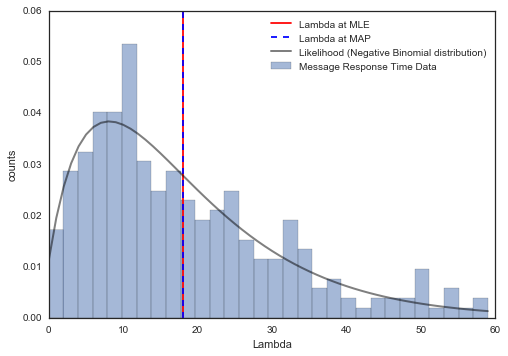

In [642]:
plt.hist(message_response_times, bins=30, alpha=0.5, normed=True, label='Message Response Time Data')
plt.axvline(x=lambda_MLE, color='r', label='Lambda at MLE')
plt.axvline(x=MAP_lambda, color='b', label='Lambda at MAP', linestyle='--')

# =====================================================
# This MU and ALPHA was got from PYMC estimation above
# =====================================================
mu = 18.111 
alpha = 1.906
xx = np.arange(0, 60)
# The parameter values were computed by refering the scipy.stats.nbinom.pmf and pymc.NegativeBinomial
negative_binomial_plot = scipy.stats.nbinom.pmf(xxp, alpha, alpha/(alpha+mu)) 
plt.plot(xx, negative_binomial_plot, color='k', alpha=0.5, linewidth=2, label="Likelihood (Negative Binomial distribution)")
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("counts")

print "log of MAP probability :", MAP_prob
print "lambda at MAP :", MAP_lambda
print "lambda at MLE :", lambda_MLE


# Problem 3: Markov Chains

* Given the following transition matrix, examine if the corresponding Markov Chain is irreducible and aperiodic. Note: No formal proof necessary, but you should give a solid argumentation.

$$ P = \left( 
\begin{array}{ccccc}
0.0 & 0.4 & 0.6 & 0.0 & 0.0 \\
0.65 & 0.0 & 0.35 & 0.0 & 0.0 \\
0.32 & 0.68 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.12 & 0.88 \\
0.0 & 0.0 & 0.0 & 0.56 & 0.44 
\end{array}
\right ) $$



<img src='http://g.gravizo.com/g?
 digraph G {
   1 -> 2 ;
   2 -> 1 ;
   1 -> 3;
   3 -> 1;
   2 -> 3;
   3 -> 2;
   4 -> 4;
   4 -> 5;
   5 -> 5;
   5 -> 4;
 }
'/>

If we reperesent the Markov Chain as the nodes above, we can evaluate the whether it is **irreducible** and **aperiodic**. First, for **irreducibility**, since Node 1, 2, 3 and Node 4, 5 they make their own isolated island, so Node 1,2,3 cannot go to Node 4, 5 and vice versa. Therefore, this Markov Chain is **reducible**.

To evaluate **aperiodic**, if we see the Node 4, 5 set, since they have rotating arrow to itself, it can rotate to itself as many as one wants to and then go back to 4 vice versa. Therefore, we cannot guarantee that each node will be visited in the fixed period. Same logic applies to Node 1, 2, 3, set too.

Therefore, this Markov chain is **reducible** and **aperiodic**.

# Problem 4: The Evidence 

In lectures we mostly concentrate on the likelihood and the prior and regard the evidence as a mere normalization factor. However, the evidence can be quite useful. In this problem you will compare different models by computing the evidence for each model, aka the probability that randomly selected parameters from a given model class would generate the data $X$.

As our models we compare polynomials of degree 0 to 4. For example for degree 2 we have $y = a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon$ where $\epsilon \sim N(0, \sigma) $ and $\theta = [a_0, a_1, a_2, \sigma]$. Assume that for all polynomials $a_i \sim \text{Expo}(1)$ and $\sigma \sim \text{Inverse Gamma}(1,1)$.


Bayes' theorem states that:
$$
P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}
$$
$P(\theta)$ is the prior, $P(x|\theta)$ is the likelihood, $P(x)$ is called the evidence, and $P(\theta|x)$ is the posterior.

Your tasks are:

* Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.
* Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?
* Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

In [186]:
# Here is your data for the problem:
data = np.array([[ -1.85519254,  -2.7009541 ],
       [  4.38291824,  19.61735369],
       [  2.29495208,   3.96481822],
       [  0.02075668,   8.00646088],
       [  0.54097177,   2.8872262 ]])

x=data[:,0]
y=data[:,1]

## 1) Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.

$$
Evidence = P(x)=\int_{\theta}\underbrace{P(x|\theta)}_\text{likelihood}\underbrace{P(\theta)}_\text{prior}d\theta
$$

## 2) Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?

The good choice for our importance sampling distribution would be the same distribution with our prior.

Let's say we define our function as follows : 
* $f(\theta) = P(x|\theta)P(\theta)$
* $g(\theta) = P(\theta) = prior$

Then our integral can be changed as :
$$
Evidence = P(x)=\int_{\theta}\underbrace{P(x|\theta)}_\text{likelihood}\underbrace{P(\theta)}_\text{prior}d\theta = \int_{\theta}f(\theta)d\theta = \int_{\theta}\frac{f(\theta)}{g(\theta)}g(\theta)d\theta = E_{Q}\Big[\frac{f(\theta)}{g(\theta)}\Big] = \frac{1}{N}\sum \frac{f(\theta)}{g(\theta)}
$$

So if we assume our choice of importance sampling distribution to be the same as prior, then
$$
\frac{f(\theta)}{g(\theta)} = P({\bf y}|\theta) = P(a_0 + a_1 \cdot {\bf x} + a_2 \cdot {\bf x^2} + \epsilon |a_0, a_1, a_2, \epsilon)
$$

And this would follow Normal distribution since each parameter in $\theta$ is given.
$$
P({\bf y}|\theta) = N(a_0 + a_1 \cdot {\bf x} + a_2 \cdot {\bf x^2} + \epsilon, \sigma)
$$

Also, each data point $(x_i, y_i)$ is independent to each other, so when we compute the likelihood above, we need to have joint likelihood, therefore it should be product of likelihood of each data point.
$$
P({\bf y}|\theta) = \prod_{n=1}^{N} P(y_i | \theta) = \prod_{n=1}^{N} N(a_0 + a_1 \cdot x_i + a_2 \cdot x_{i}^2 + \epsilon, \sigma)
$$
Now, let's solve this integral using importance sampling

### Degree 0

Mean importance sampling MC estimate:  1.04658838453e-09
Standard deviation of our estimates:  1.3421454196e-10


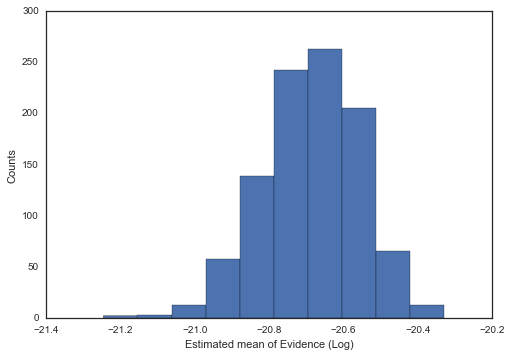

In [275]:
mu_function0 = lambda a0, e: a0 + e

p = lambda y, sig, mu: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(y-mu)**2/(2.0*sig**2))

# Number of draws 
N = 1000


# ============================================
# IMPORTANCE SAMPLING 
# ============================================
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    p_for_each_xy = 1
    
    # draw paramters
    a0 = np.random.exponential(scale=1.0, size=N)
    sig = scipy.stats.invgamma.rvs(a=1.0, size=N)
    e = 0 + sig*np.random.normal(size=N)
    mu = mu_function0(a0, e)

    # have product of our estimates
    for i in range(len(x)):
        p_for_each_xy = p_for_each_xy * p(y[i], sig, mu)

    Iis[k] = np.mean(p_for_each_xy)

print "Mean importance sampling MC estimate: ", np.mean(Iis)
print "Standard deviation of our estimates: ", np.std(Iis)

plt.hist(np.log(Iis))
plt.xlabel("Estimated mean of Evidence (Log)")
plt.ylabel("Counts")

### Degree 1

Mean importance sampling MC estimate:  1.08383746529e-09
Standard deviation of our estimates:  1.39608985497e-10


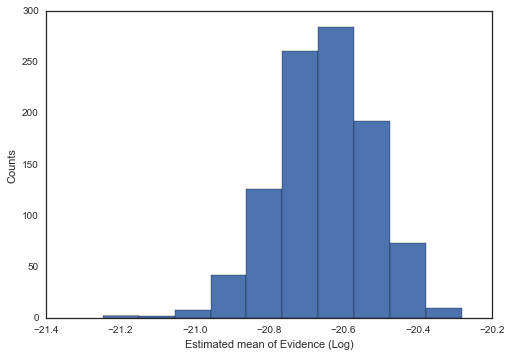

In [281]:
mu_function1 = lambda a0, a1, e, x: a0 + a1*x + e

p = lambda y, sig, mu: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(y-mu)**2/(2.0*sig**2))

# Number of draws 
N = 1000


# ============================================
# IMPORTANCE SAMPLING 
# ============================================
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    p_for_each_xy = 1
    
    # draw paramters
    a0 = np.random.exponential(scale=1.0, size=N)
    a1 = np.random.exponential(scale=1.0, size=N)
    sig = scipy.stats.invgamma.rvs(a=1.0, size=N)
    e = 0 + sig*np.random.normal(size=N)
    mu = mu_function1(a0, a1, e, x[i])

    # computing our estimates
    for i in range(len(x)):
        p_for_each_xy = p_for_each_xy * p(y[i], sig, mu)
    
    Iis[k] = np.mean(p_for_each_xy)

print "Mean importance sampling MC estimate: ", np.mean(Iis)
print "Standard deviation of our estimates: ", np.std(Iis)

plt.hist(np.log(Iis))
plt.xlabel("Estimated mean of Evidence (Log)")
plt.ylabel("Counts")

### Degree 2

Mean importance sampling MC estimate:  6.41261294991e-08
Standard deviation of our estimates:  1.51224190017e-07


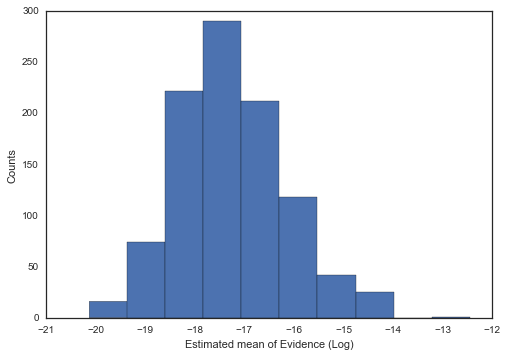

In [280]:
mu_function2 = lambda a0, a1, a2, e, x: a0 + a1*x + a2*(x**2) + e

p = lambda y, sig, mu: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(y-mu)**2/(2.0*sig**2))

# Number of draws 
N = 1000


# ============================================
# IMPORTANCE SAMPLING 
# ============================================
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    p_for_each_xy = 1
    for i in range(len(x)):
        # draw paramters
        a0 = np.random.exponential(scale=1.0, size=N)
        a1 = np.random.exponential(scale=1.0, size=N)
        a2 = np.random.exponential(scale=1.0, size=N)

        sig = scipy.stats.invgamma.rvs(a=1.0, size=N)
        e = 0 + sig*np.random.normal(size=N)
        mu = mu_function2(a0, a1, a2, e, x[i])

        # computing our estimates
        p_for_each_xy = p_for_each_xy * p(y[i], sig, mu)
    
    Iis[k] = np.mean(p_for_each_xy)

print "Mean importance sampling MC estimate: ", np.mean(Iis)
print "Standard deviation of our estimates: ", np.std(Iis)

plt.hist(np.log(Iis))
plt.xlabel("Estimated mean of Evidence (Log)")
plt.ylabel("Counts")

### Degree 3

Mean importance sampling MC estimate:  4.65154151543e-09
Standard deviation of our estimates:  1.59293375841e-08


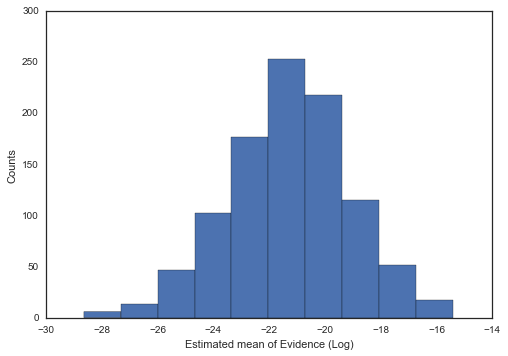

In [277]:
mu_function3 = lambda a0, a1, a2, a3, e, x: a0 + a1*x + a2*(x**2) + a3*(x**3) + e

p = lambda y, sig, mu: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(y-mu)**2/(2.0*sig**2))

# Number of draws 
N = 1000


# ============================================
# IMPORTANCE SAMPLING 
# ============================================
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    p_for_each_xy = 1
    for i in range(len(x)):
        # draw paramters
        a0 = np.random.exponential(scale=1.0, size=N)
        a1 = np.random.exponential(scale=1.0, size=N)
        a2 = np.random.exponential(scale=1.0, size=N)
        a3 = np.random.exponential(scale=1.0, size=N)

        sig = scipy.stats.invgamma.rvs(a=1.0, size=N)
        e = 0 + sig*np.random.normal(size=N)
        mu = mu_function3(a0, a1, a2, a3, e, x[i])

        # computing our estimates
        p_for_each_xy = p_for_each_xy * p(y[i], sig, mu)
    
    Iis[k] = np.mean(p_for_each_xy)

print "Mean importance sampling MC estimate: ", np.mean(Iis)
print "Standard deviation of our estimates: ", np.std(Iis)

plt.hist(np.log(Iis))
plt.xlabel("Estimated mean of Evidence (Log)")
plt.ylabel("Counts")

### Degree 4

Mean importance sampling MC estimate:  1.83479742224e-12
Standard deviation of our estimates:  1.81678117147e-11


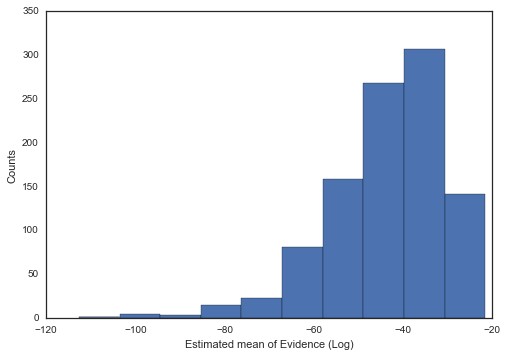

In [279]:
mu_function4 = lambda a0, a1, a2, a3, a4, e, x: a0 + a1*x + a2*(x**2) + a3*(x**3) + a4*(x**4) + e

p = lambda y, sig, mu: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(y-mu)**2/(2.0*sig**2))

# Number of draws 
N = 1000


# ============================================
# IMPORTANCE SAMPLING 
# ============================================
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    p_for_each_xy = 1
    for i in range(len(x)):
        # draw paramters
        a0 = np.random.exponential(scale=1.0, size=N)
        a1 = np.random.exponential(scale=1.0, size=N)
        a2 = np.random.exponential(scale=1.0, size=N)
        a3 = np.random.exponential(scale=1.0, size=N)
        a4 = np.random.exponential(scale=1.0, size=N)

        sig = scipy.stats.invgamma.rvs(a=1.0, size=N)
        e = 0 + sig*np.random.normal(size=N)
        mu = mu_function4(a0, a1, a2, a3, a4, e, x[i])

        # computing our estimates
        p_for_each_xy = p_for_each_xy * p(y[i], sig, mu)
    
    Iis[k] = np.mean(p_for_each_xy)

print "Mean importance sampling MC estimate: ", np.mean(Iis)
print "Standard deviation of our estimates: ", np.std(Iis)

plt.figure(figsize=(6,4))
plt.hist(np.log(Iis))
plt.xlabel("Estimated mean of Evidence (Log)")
plt.ylabel("Counts")

## 3) Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

| Polynomials Degree | Evidence        | Error (std)     |
|:-------------------|:---------------:|:---------------:|
| degree 0           |1.04658838453e-09|1.34214541960e-10
| degree 1           |1.08852630548e-09|1.36736691798e-10
| degree 2           |6.69482188338e-08|1.34580218165e-07
| degree 3           |4.65154151543e-09|1.59293375841e-08
| degree 4           |1.83479742224e-12|1.81678117147e-11

From the table, we can see that degree 2 has the highest Evidence value, so **degree 2** wins.

# Problem 5: Which YouTube Videos to Watch

Youtube videos have a like and an unlike flag. We can use these up and down votes on the videos to determine if a video is worth watching. However, it is not immediately obvious how to rank a video with just 3 up and 0 down rankings against a video with 300 up and 100 down votes. We will address this problem using a Bayesian approach.

Build two Bayesian models for the average upvote rate of a video. Both models should use the same likelihood, but different priors. Use one prior where people in general are rather undecided about videos, and one where people tend to be very opinionated. Compare the resulting posteriors for each video. How does the different choice of prior change your results? 

Given that there are so many videos on YouTube we want a really conservative way to decide if it is worth watching. Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

In [317]:
# Here is the [upvote, downvote] data for 4 different videos:
video_votes = np.array([[3,0],[300,100],[2,2],[200,100]])

## 1) Build two Bayesian models

* For likelihood, I'll choose Binomial distribution because we can say that each video is upvoted by number of people and each person upvote the video with the given probability of "average upvote rate"
* For prior, I'll choose Beta distribution because of two reasons : first it is conjugate of Binomial, and second, it is useful to represent a model that reflects whether people are rather undecided about videos or people tend to be very opinionated, by setting different $\alpha$ and $\beta$ values.
* For the case **'people are rather undecided about videos'**, prior would be Beta distribution of $\bf \alpha = 1, \beta = 1$ as it gives us uniform distribution.
* For the case **'people tend to be very opinionated'**, prior would be Beta distribution of $\bf \alpha = 0.5, \beta = 0.5$ as it has open-up-parabola shape, meaning it has high probability at the either extreme upvote rate of [0, 1].

So finally, since binomial likelihood and beta prior will give us beta distribution as posterior, so I can define my Bayesian model as follows.

* people are rather undecided about videos ~ Beta( $\theta$, k + 1, n - k + 1 )
* people tend to be very opinionated ~ Beta( $\theta$, k + 0.5, n - k + 0.5 )

## 2) Compare the resulting posteriors for each video. How does the different choice of prior change your results?

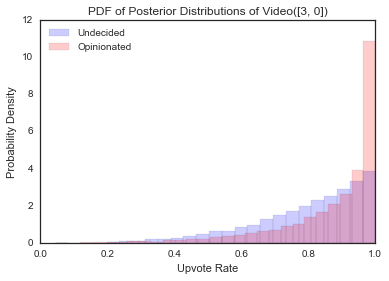

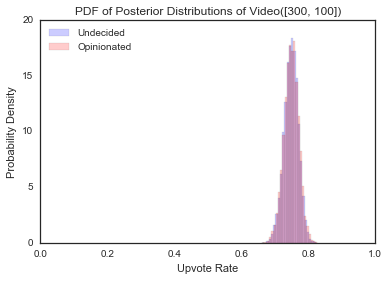

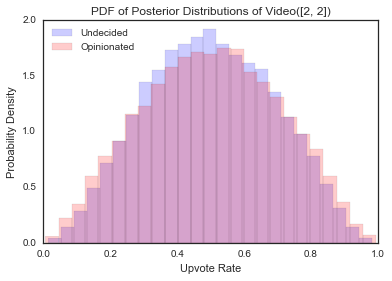

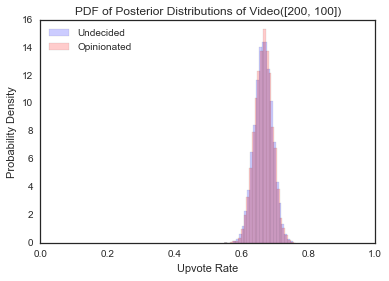

In [610]:
N = 10000

for i in range(len(video_votes)):
    x = video_votes[i]
    upvote, downvote = x[0], x[1]
    k = upvote
    n = upvote + downvote

    undecided_beta = np.random.beta(k+1, n-k+1, N)
    opinionated_beta = np.random.beta(k+0.5, n-k+0.5, N)
    
    plt.figure(figsize=(6,4))
    plt.hist(undecided_beta,25,normed=1, alpha=0.2, color='b', label='Undecided')
    plt.hist(opinionated_beta,25,normed=1, alpha=0.2, color='r', label='Opinionated')
    plt.xlabel("Upvote Rate")
    plt.ylabel("Probability Density")
    plt.title("PDF of Posterior Distributions of Video(["+str(upvote)+", "+str(downvote)+"])")
    plt.xlim(0,1)
    plt.legend(loc=2)

When we see the first case, Video([3, 0]) case, the 2 different priors make the difference quite big. However, rest of the cases were 

## 3) Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

For Video([3, 0]) 	Undecided 5% = 0.472870804502 / Opinionated 5% = 0.555932890539
For Video([300, 100]) 	Undecided 5% = 0.712521305205 / Opinionated 5% = 0.713123302574
For Video([2, 2]) 	Undecided 5% = 0.189255377438 / Opinionated 5% = 0.165280266656
For Video([200, 100]) 	Undecided 5% = 0.620354740162 / Opinionated 5% = 0.620845235027


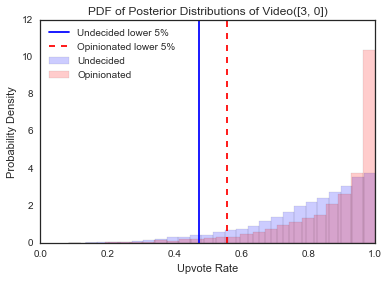

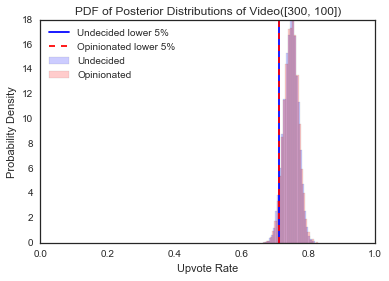

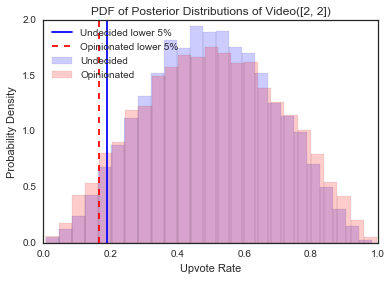

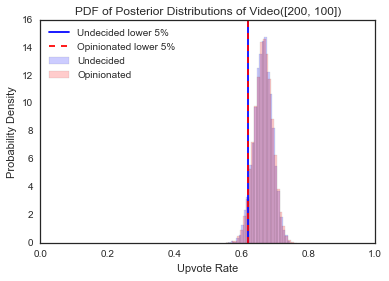

In [395]:
N = 10000

for i in range(len(video_votes)):
    x = video_votes[i]
    upvote, downvote = x[0], x[1]
    k = upvote
    n = upvote + downvote

    undecided_beta = np.random.beta(k+1, n-k+1, N)
    opinionated_beta = np.random.beta(k+0.5, n-k+0.5, N)
    
    undecided_5percent = scipy.stats.beta.ppf(0.05, k+1, n-k+1)
    opinionated_5percent = scipy.stats.beta.ppf(0.05, k+0.5, n-k+0.5)
    print "For Video(["+str(upvote)+", "+str(downvote)+"]) \t", "Undecided 5% =", undecided_5percent, "/ Opinionated 5% =", opinionated_5percent

    plt.figure(figsize=(6,4))
    plt.hist(undecided_beta,25,normed=1, alpha=0.2, color='b', label='Undecided')
    plt.hist(opinionated_beta,25,normed=1, alpha=0.2, color='r', label='Opinionated')
    plt.axvline(undecided_5percent, color='b', label='Undecided lower 5%')
    plt.axvline(opinionated_5percent, color='r', linestyle = '--', label='Opinionated lower 5%')
    plt.xlabel("Upvote Rate")
    plt.ylabel("Probability Density")
    plt.title("PDF of Posterior Distributions of Video(["+str(upvote)+", "+str(downvote)+"])")
    plt.xlim(0,1)
    plt.legend(loc=2)

According to lower 5 percentile criteria, then the rank of the given videos can be decided as follows.

* For Video([300, 100]) 	Undecided 5% = 0.712521305205 / Opinionated 5% = 0.713123302574
* For Video([200, 100]) 	Undecided 5% = 0.620354740162 / Opinionated 5% = 0.620845235027
* For Video([3, 0]) 	    Undecided 5% = 0.472870804502 / Opinionated 5% = 0.555932890539
* For Video([2, 2]) 	    Undecided 5% = 0.189255377438 / Opinionated 5% = 0.165280266656

I think this 5% criteria is quite good and reliable way to rank the videos. As we see the graphs above, if we have relatively larger number of data, (for the case of Video([300, 100]) and Video([200, 100])) their variance gets quite small, so that 5% threshold is also quite near to mean value so it can be good enough to coompare the videos. Vice versa, if the number of votes are not large enough, then even though the video got perfect upvotes (for the case of Video([3, 0])), we cannot perfectly rely on by seeing the naiive upvote rate, since the data is not enough and it has high probability to get downvote in the future when votes get larger. So our posterior also catches such property as well. If data is small, then the variance get larger, thereby making 5% threshold to be far from the mean value so that we don't blindly believe the naiive mean upvote rate. I think these will be the benefits of using this way to rate videos.

Potential drawbacks would be dependacy on our prior. Since we assumed that people will be either undecided or opinionated, if the data size is small, then it gets affected largely on the prior. Since our belief on the prior is just belief, it will have high uncertainty when data size is small.
